In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import scipy

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)
library(MAST)

Loading required package: limma
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2

# Preparing the dataset

In [3]:
adata = sc.read(
    filename='kang.h5ad',
    # backup_url='https://figshare.com/ndownloader/files/34464122'
)

  0%|          | 0.00/36.6M [00:00<?, ?B/s]

In [4]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [5]:
adata.obs[:5]

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


In [6]:
# We will need label (which contains the condition label), `replicate` and `cell_type` columns of the .obs.
adata.obs['replicate'].value_counts()

patient_1015    5090
patient_1488    4580
patient_1256    4134
patient_1016    3358
patient_1244    3343
patient_101     2024
patient_1039    1102
patient_107     1042
Name: replicate, dtype: int64

In [7]:
np.max(adata.X)

3828.0

In [8]:
# We will need to work with raw counts
adata.layers["counts"] = adata.X.copy()

In [9]:
print(len(adata[adata.obs["label"] == "ctrl"].obs["replicate"].cat.categories))
print(len(adata[adata.obs["label"] == "stim"].obs["replicate"].cat.categories))

8
8


In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'name', 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

# Pseudobulk

 For each patient we create 1 pseudobulk sample per cell type by aggregating the cell from each subpopulation and taking the mean gene expression within that subpopulation.

 We strongly recommend to read this guide https://f1000research.com/articles/9-1444 on design matrices.

In [11]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [13]:
# We need to clean up the cell type names, i.e. replace spaces with underscores and remove + symbols, to avoid Python to R conversion issues.
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]

In [14]:
# set categorical metadata to be indeed categorical
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [26]:
adata.obs

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters,n_genes,sample
index,,,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14_Monocytes,patient_1016,1704.0,711,1,1,877,patient_1016_ctrl
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14_Monocytes,patient_1256,1614.0,662,1,1,713,patient_1256_ctrl
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4_T_cells,patient_1488,908.0,337,6,6,337,patient_1488_ctrl
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14_Monocytes,patient_1256,1738.0,653,1,1,850,patient_1256_ctrl
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic_cells,patient_1039,1857.0,928,12,12,1111,patient_1039_ctrl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGCCTGAA-2,1033.0,468,18.268321,1.058202,stim,6,CD4_T_cells,patient_1244,1128.0,468,2,2,468,patient_1244_stim
TTTGCATGCCTGTC-2,2116.0,819,-11.563067,2.574095,stim,4,B_cells,patient_1256,1669.0,799,3,3,819,patient_1256_stim
TTTGCATGCTAAGC-2,1522.0,523,25.142392,6.603815,stim,6,CD4_T_cells,patient_107,1422.0,523,0,0,523,patient_107_stim


In [28]:
adata.obs_names

Index(['AAACATACATTTCC-1', 'AAACATACCAGAAA-1', 'AAACATACCATGCA-1',
       'AAACATACCTCGCT-1', 'AAACATACCTGGTA-1', 'AAACATACGATGAA-1',
       'AAACATACGCCAAT-1', 'AAACATACGCTTCC-1', 'AAACATACGGCATT-1',
       'AAACATACGTGTAC-1',
       ...
       'TTTGCATGAACGAA-2', 'TTTGCATGACGTAC-2', 'TTTGCATGAGGTTC-2',
       'TTTGCATGAGTGTC-2', 'TTTGCATGCATGAC-2', 'TTTGCATGCCTGAA-2',
       'TTTGCATGCCTGTC-2', 'TTTGCATGCTAAGC-2', 'TTTGCATGGGACGA-2',
       'TTTGCATGTCTTAC-2'],
      dtype='object', name='index', length=24562)

In [16]:
NUM_OF_CELL_PER_DONOR = 30


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    """
    Creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData objec

    Parameters:
    ----------
        adata: AnnData object
        cell_identity: str, cell type to subset the AnnData object
        donor_key: str, column name of the donor metadata
        condition_key: str, column name of the condition metadata
        cell_identity_key: str, column name of the cell identity metadata
        obs_to_keep: list, additional metadata to keep
        replicates_per_patient: int, number of pseudo-replicates to create for each donor
    
    Returns:
    -------
        adata_cell_pop: AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData objec
    
    """
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR  # keep donors with more than NUM_OF_CELL_PER_DONOR cells
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [17]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [18]:
obs_to_keep = ["label", "cell_type", "replicate", "sample"]

In [19]:
adata.X = adata.layers["counts"].copy()

In [20]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)

for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing B_cells (1 out of 8)...
Dropping the following samples:
['patient_1039_ctrl']
	Processing donor 16 out of 16...

Processing CD14_Monocytes (2 out of 8)...
	Processing donor 16 out of 16...

Processing CD4_T_cells (3 out of 8)...
	Processing donor 16 out of 16...

Processing CD8_T_cells (4 out of 8)...
Dropping the following samples:
['patient_101_ctrl', 'patient_1039_ctrl', 'patient_1039_stim', 'patient_107_ctrl', 'patient_107_stim', 'patient_1244_ctrl', 'patient_1244_stim']
	Processing donor 16 out of 16...

Processing Dendritic_cells (5 out of 8)...
Dropping the following samples:
['patient_1016_ctrl', 'patient_1016_stim', 'patient_101_ctrl', 'patient_1039_ctrl', 'patient_1039_stim', 'patient_107_ctrl', 'patient_107_stim']
	Processing donor 16 out of 16...

Processing FCGR3A_Monocytes (6 out of 8)...
Dropping the following samples:
['patient_1039_ctrl', 'patient_1039_stim', 'patient_107_ctrl', 'patient_107_stim', 'patient_1244_stim']
	Processing donor 16 out of 16...

Proc

In [65]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [66]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [67]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"].astype('float64'), axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype('float64'))

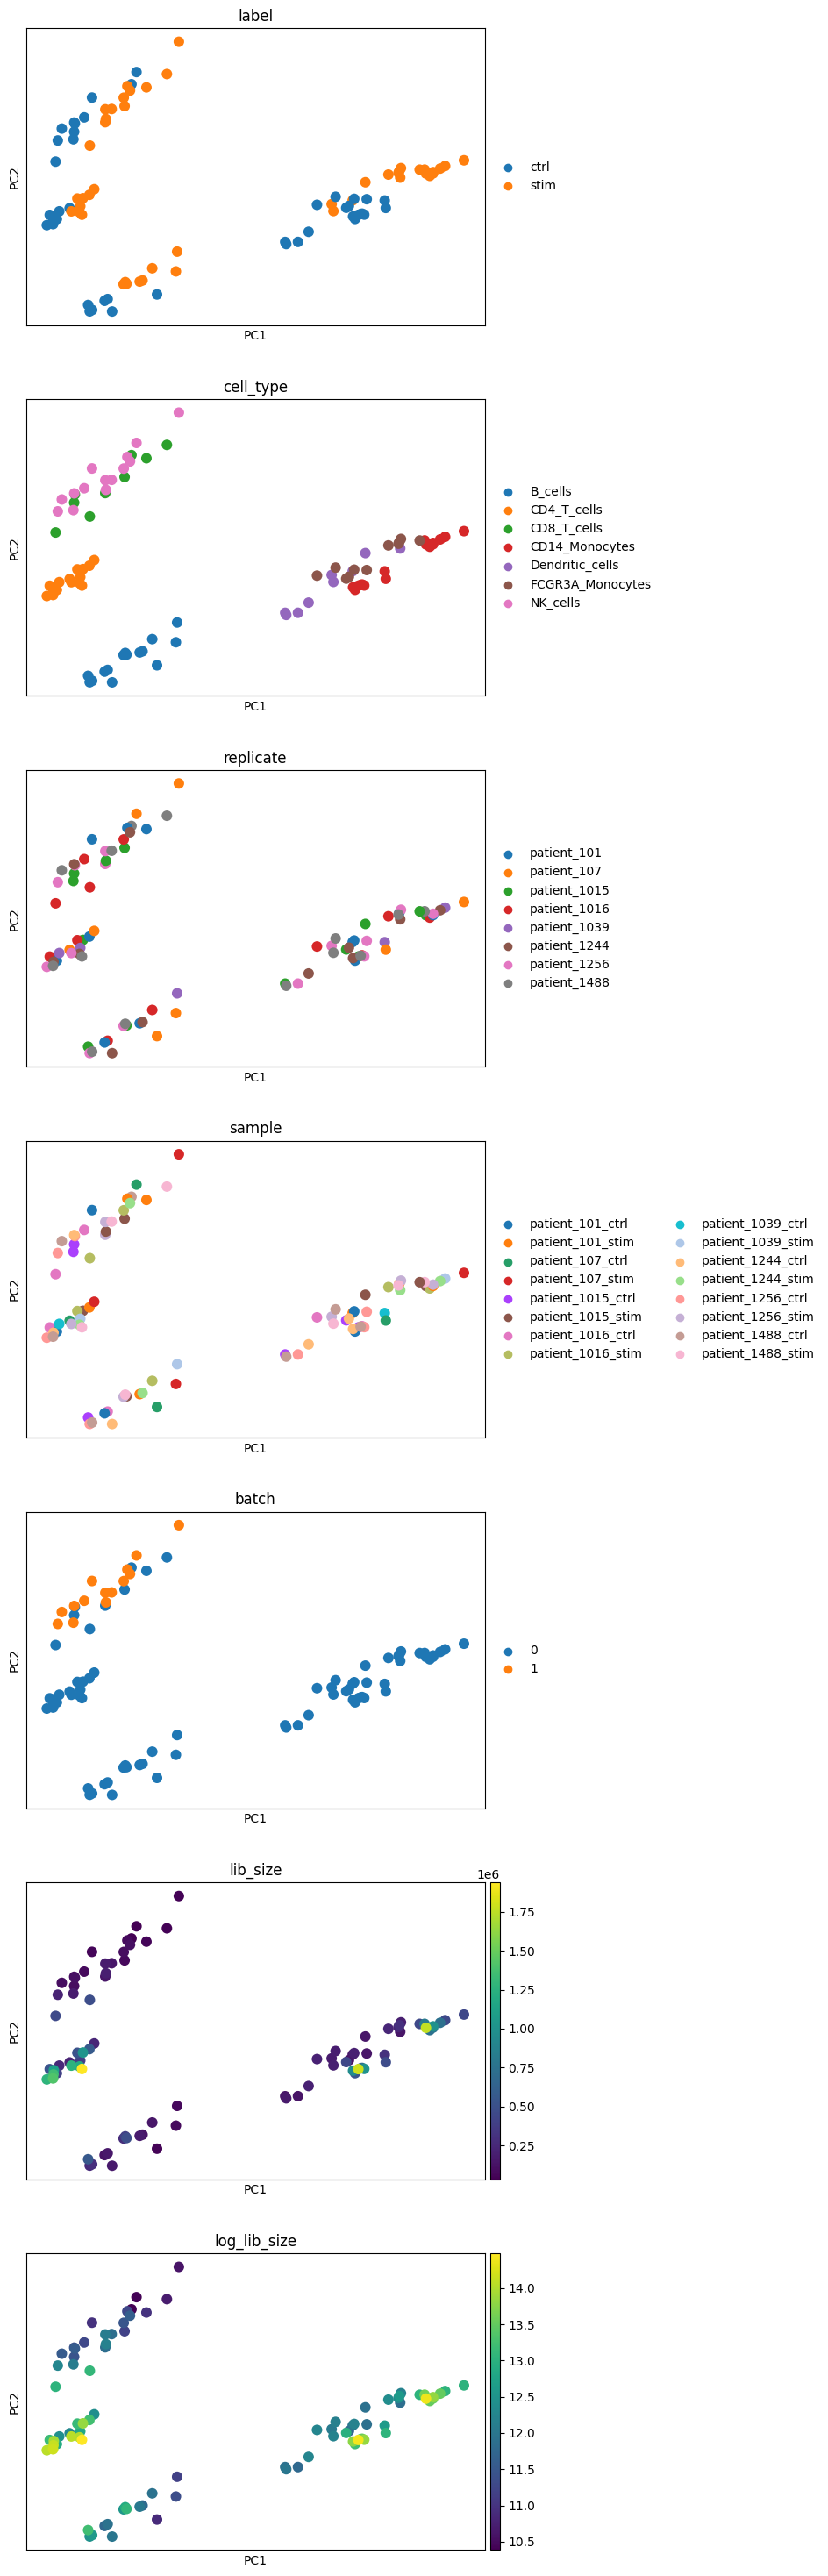

In [68]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [69]:
# edgeR takes raw couts as input, so we put counts back into the .X field before we proceed.
adata_pb.X = adata_pb.layers['counts'].copy()

## One group

In [116]:
# We run the pipeline on CD14+ Monocytes subset of the data
adata_mono = adata_pb[adata_pb.obs["cell_type"] == "CD14_Monocytes"].copy()
adata_mono

AnnData object with n_obs × n_vars = 16 × 15701
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [123]:
adata_mono.layers['counts'] = scipy.sparse.csc_matrix(adata_mono.layers['counts'].astype('float64'))
adata_mono.X = adata_mono.layers['counts']

In [124]:
# Clean the sample names to make plots less crowded.
adata_mono.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_mono.obs_names
]

In [125]:
%%R -i adata_mono
outs <-fit_model(adata_mono)

[1] "Dimensions before subsetting:"
[1] 15701    16
[1] ""
[1] "Dimensions after subsetting:"
[1] 3709   16
[1] ""


In [126]:
%%R
fit <- outs$fit
y <- outs$y

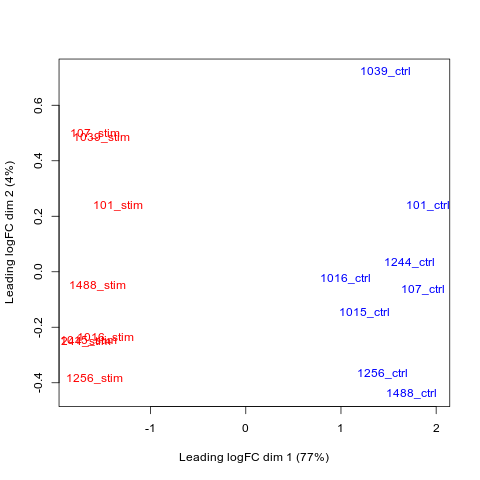

In [127]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

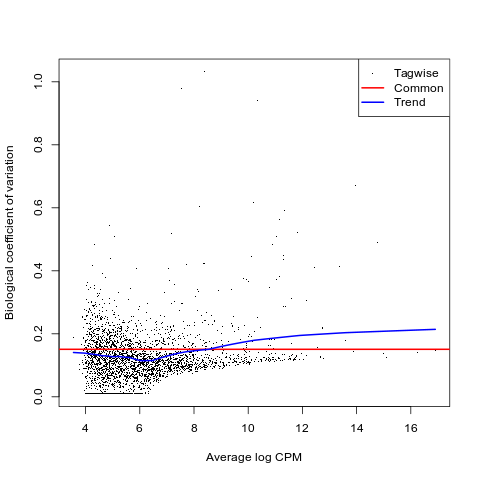

In [128]:
%%R
plotBCV(y)

In [130]:
%%R
# Next, we perform the quasi-likelihood test to find DE genes between control and stimulated conditions. Let’s check what columns our design matrix has to specify the correct columns to test on.
colnames(y$design)

[1] "groupctrl.CD14_Monocytes" "groupstim.CD14_Monocytes"
[3] "replicatepatient_107"     "replicatepatient_1015"   
[5] "replicatepatient_1016"    "replicatepatient_1039"   
[7] "replicatepatient_1244"    "replicatepatient_1256"   
[9] "replicatepatient_1488"   


In [131]:
%%R -o tt
myContrast <- makeContrasts('groupstim.CD14_Monocytes-groupctrl.CD14_Monocytes', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [133]:
tt.shape

(3709, 5)

In [132]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
HESX1,8.345536,6.773420,1281.013295,1.837373e-15,2.766927e-12
CD38,7.126846,7.420668,1243.793133,2.266164e-15,2.766927e-12
NT5C3A,5.657050,8.327003,1218.102628,2.628780e-15,2.766927e-12
SOCS1,4.388247,6.943768,1191.289806,3.079524e-15,2.766927e-12
GMPR,6.943484,7.031832,1159.601183,3.730018e-15,2.766927e-12


In [134]:
%%R
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)
print(head(topTags(tr)))

Coefficient:  -1*groupctrl.CD14_Monocytes 1*groupstim.CD14_Monocytes 
          logFC unshrunk.logFC    logCPM       PValue          FDR
HESX1  8.345536       8.702486  6.773420 2.108737e-14 3.535749e-11
CD38   7.126846       7.219184  7.420668 2.292459e-14 3.535749e-11
NT5C3A 5.657050       5.674640  8.327003 3.149544e-14 3.535749e-11
IL1RN  6.588583       6.596787 10.358946 4.249159e-14 3.535749e-11
GMPR   6.943484       7.047504  7.031832 4.766446e-14 3.535749e-11
DEFB1  6.654201       6.696759  8.067159 7.670147e-14 4.741429e-11


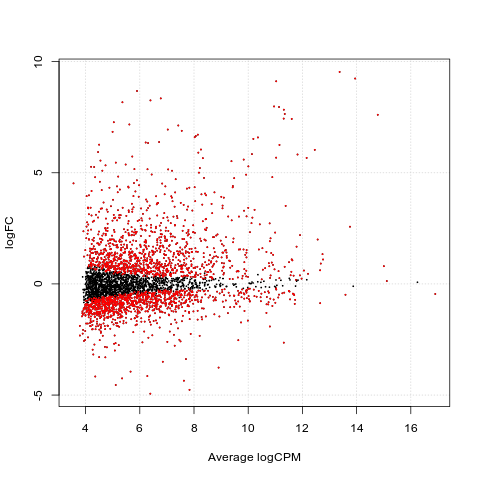

In [135]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

## Multiple groups

In [140]:
adata_pb.layers['counts'] = scipy.sparse.csc_matrix(adata_pb.layers['counts'].astype('float64'))
adata_pb.X = adata_pb.layers['counts']

In [141]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

[1] "Dimensions before subsetting:"
[1] 15701    90
[1] ""
[1] "Dimensions after subsetting:"
[1] 2358   90
[1] ""
CPU times: user 44.8 s, sys: 257 ms, total: 45.1 s
Wall time: 10.2 s


In [142]:
%%R
fit <- outs$fit
y <- outs$y

In [143]:
%%R -i adata_pb -o de_per_cell_type

# Now we use contrasts to perform a quasi-likelihood test for each of our cell types
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupstim.", cell_type, "-groupctrl.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}

[1] "B_cells"
[1] "CD14_Monocytes"
[1] "CD4_T_cells"
[1] "CD8_T_cells"
[1] "Dendritic_cells"
[1] "FCGR3A_Monocytes"
[1] "NK_cells"


In [144]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

In [145]:
df

,logFC,logCPM,F,PValue,FDR,gene_symbol,cell_type
ISG20,3.547886,12.104120,337.506350,7.029878e-31,1.657645e-27,ISG20,NK_cells
PLSCR1,3.864405,9.897077,328.133046,1.787129e-30,2.107026e-27,PLSCR1,NK_cells
IFIT3,5.489423,11.056149,299.779703,3.442893e-29,2.706114e-26,IFIT3,NK_cells
IFI6,5.322134,10.921113,274.866602,5.589898e-28,3.295245e-25,IFI6,NK_cells
BST2,2.112347,10.000014,251.879470,8.750114e-27,4.126554e-24,BST2,NK_cells
...,...,...,...,...,...,...,...
MTCH1,0.002788,7.014626,0.000128,9.962996e-01,9.979925e-01,MTCH1,NK_cells
EPC1,0.000865,6.375797,0.000012,9.972519e-01,9.985223e-01,EPC1,NK_cells
ZNF22,0.000487,6.067425,0.000005,9.981707e-01,9.988978e-01,ZNF22,NK_cells
EWSR1,-0.012486,7.341974,0.004871,9.984742e-01,9.988978e-01,EWSR1,NK_cells


In [146]:
sc.get.rank_genes_groups_df(adata, group="CD14_Monocytes", key="edgeR_CD14_Monocytes")[
    :5
]

,names,scores,logfoldchanges,pvals,pvals_adj
0,FTH1,16.186076,-0.57216,0.001592,0.002717
1,MALAT1,16.025682,0.010162,0.875701,0.895836
2,B2M,15.468525,0.677371,0.0,0.0
3,TMSB4X,15.054699,-0.217035,0.004681,0.007358
4,FTL,14.984911,-0.041735,0.670674,0.711253


In [147]:
adata

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'edgeR_B_cells', 'edgeR_CD14_Monocytes', 'edgeR_CD4_T_cells', 'edgeR_CD8_T_cells', 'edgeR_Dendritic_cells', 'edgeR_FCGR3A_Monocytes', 'edgeR_NK_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

**Notes on edgeR:**

 - Requires raw counts as input

 - Requires pseudobulks from a single-cell experiment

 - If there are several donors in the single-cell experiment and the user wants to account for the patient varianility, we recommend creating 2 or 3 pseudo-replicates for each patient and including patient information into the design matrix

# Single-cell specific

In [148]:
# MAST takes normalized counts as input, so we first take the ‘counts’ layer and then perform the normalization step.
adata.X = adata.layers["counts"].copy()

In [149]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [150]:
def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

## One group

In [151]:
adata_mono = adata[adata.obs["cell_type"] == "CD14_Monocytes"].copy()
adata_mono

AnnData object with n_obs × n_vars = 5696 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'edgeR_B_cells', 'edgeR_CD14_Monocytes', 'edgeR_CD4_T_cells', 'edgeR_CD8_T_cells', 'edgeR_Dendritic_cells', 'edgeR_FCGR3A_Monocytes', 'edgeR_NK_cells', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [152]:
sc.pp.filter_genes(adata_mono, min_cells=3)
adata_mono

AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'edgeR_B_cells', 'edgeR_CD14_Monocytes', 'edgeR_CD4_T_cells', 'edgeR_CD8_T_cells', 'edgeR_Dendritic_cells', 'edgeR_FCGR3A_Monocytes', 'edgeR_NK_cells', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [153]:
adata_mono = prep_anndata(adata_mono)
adata_mono

AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'n_cells'

In [154]:
adata_mono.obs["cell_type"] = [
    ct.replace(" ", "_") for ct in adata_mono.obs["cell_type"]
]
adata_mono.obs["cell_type"] = [
    ct.replace("+", "") for ct in adata_mono.obs["cell_type"]
]

In [155]:
%%R
find_de_MAST_RE <- function(adata_){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    label <- factor(colData(sca)$label)
    # set the reference level
    label <- relevel(label,"ctrl")
    colData(sca)$label <- label
    celltype <- factor(colData(sca)$cell_type)
    colData(sca)$celltype <- celltype
    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$replicate)
    colData(sca)$replicate <- replicate
    # create a group per condition-celltype combination
    colData(sca)$group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    colData(sca)$group <- factor(colData(sca)$group)
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in    
    summaryCond <- summary(zlmCond, doLRT='groupstim.CD14_Monocytes')
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

In [157]:
%%time
%%R -i adata_mono -o res
res <-find_de_MAST_RE(adata_mono)

[1] "Dimensions before subsetting:"
[1] 12268  5696
[1] ""
[1] "Dimensions after subsetting:"
[1] 1676 5696
[1] ""


`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name X is log-transformed.
Loading required namespace: lme4

Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!


CPU times: user 9min 23s, sys: 3.78 s, total: 9min 27s
Wall time: 7min 45s


In [158]:
res[:5]

,primerid,Pr(>Chisq),coef,FDR
1,AAED1,8.410341e-19,0.709836,1.597106e-18
2,ABI1,1.401688e-05,0.312797,1.824921e-05
3,ABRACL,3.920183e-06,0.418028,5.201004e-06
4,ACADVL,2.121110e-26,-0.751305,4.656979e-26
5,ACOT9,3.424174e-151,2.921133,2.689503e-150


In [159]:
res["gene_symbol"] = res["primerid"]
res["cell_type"] = "CD14_Monocytes"
sc_toolbox.tools.de_res_to_anndata(
    adata,
    res,
    groupby="cell_type",
    score_col="coef",
    pval_col="Pr(>Chisq)",
    pval_adj_col="FDR",
    lfc_col="coef",
    key_added="MAST_CD14_Monocytes",
)

# Visualization

In [160]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [161]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, group_key, group_name="cell_type", groupby="label"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
    )

Plotting 303 genes...


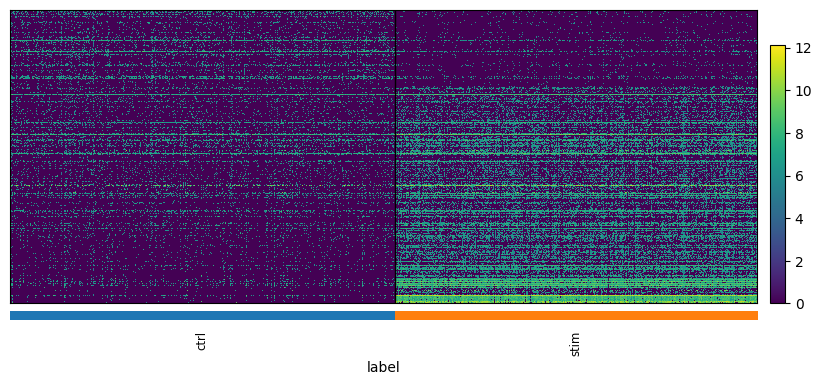

In [162]:
plot_heatmap(adata, "edgeR_CD14_Monocytes")

Plotting 436 genes...


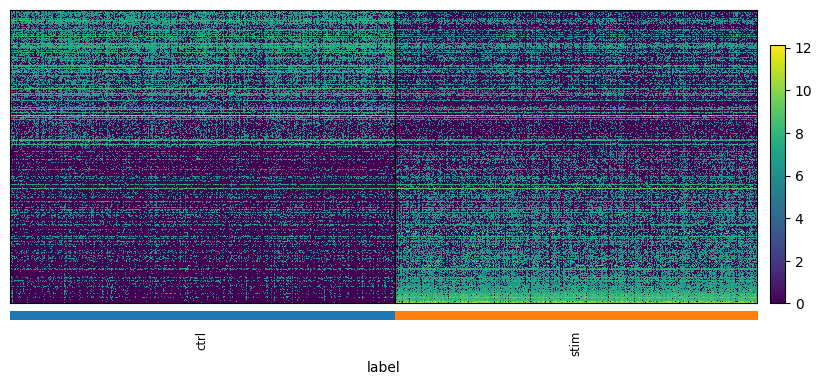

In [163]:
plot_heatmap(adata, "MAST_CD14_Monocytes")

In [164]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

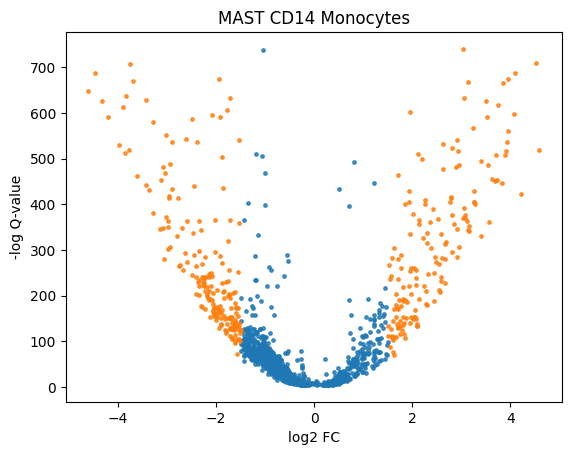

In [165]:
volcano_plot(adata, "MAST_CD14_Monocytes")

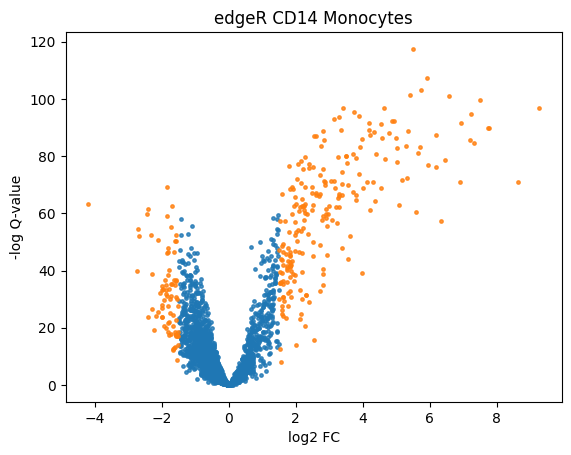

In [166]:
volcano_plot(adata, "edgeR_CD14_Monocytes")

**Key Takeaways**

- Repeated measurements (cells) from the same experimental subject in scRNA-seq introduce correlations between measurements, which need to be adjusted by modeling the experimental units as Random Effect to mitigate the pseudoreplication issue. Account for them through a sum or mean aggregation (pseudobulk methods - by fixed- or random effect terms) or by accounting for individual as a random effect (single-cell methods) to mitigate the pseudoreplication issue.

- Determine the major axis of variation with exploratory analysis to construct an appropriate design matrix to better model the variations in the data.

- Statistical power is best increased with more samples in the experimental design.